In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carolina-cupboard-data-fall-2023-spring-2025/Carolina Cupboard Data Fall 2023-Spring 2025.xlsx


In [11]:
file_path = '/kaggle/input/carolina-cupboard-data-fall-2023-spring-2025/Carolina Cupboard Data Fall 2023-Spring 2025.xlsx'
df = pd.read_excel(file_path, sheet_name='Master Spreadsheet', engine='openpyxl')

# Preview the data
df.head()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1692 non-null   datetime64[ns]
 1   PID     1682 non-null   object        
 2   First   1685 non-null   object        
 3   Last    1642 non-null   object        
 4   Weight  1692 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 66.2+ KB


Date       0
PID       10
First      7
Last      50
Weight     0
dtype: int64

In [12]:
# Analyzing by semester
df['Date'] = pd.to_datetime(df['Date'])
def assign_semester(date):
    if pd.Timestamp('2023-08-01') <= date <= pd.Timestamp('2023-12-31'):
        return 'Fall 2023'
    elif pd.Timestamp('2024-01-01') <= date <= pd.Timestamp('2024-05-31'):
        return 'Spring 2024'
    elif pd.Timestamp('2024-08-01') <= date <= pd.Timestamp('2024-12-31'):
        return 'Fall 2024'
    elif pd.Timestamp('2025-01-01') <= date <= pd.Timestamp('2025-05-31'):
        return 'Spring 2025'
    else:
        return 'Other'

df['Semester'] = df['Date'].apply(assign_semester)
semester_order = ['Fall 2023', 'Spring 2024', 'Fall 2024', 'Spring 2025']
# This keeps it ordered in the semester_order even if I add more the the future
df['Semester'] = pd.Categorical(df['Semester'], categories=semester_order, ordered=True)

df.head()

,Date,PID,First,Last,Weight,Semester
0,2023-09-19,730651154,Leila,Gienece,6.0,Fall 2023
1,2023-09-19,730680558,Victor,Ajayi,7.0,Fall 2023
2,2023-09-19,730684350,Tiffany,Jones,8.0,Fall 2023
3,2023-09-20,730400690,Jasmine,Inthavong,14.0,Fall 2023
4,2023-09-20,730424334,Nicole,Brown,10.0,Fall 2023


In [13]:
# Counting entrys per semester

Semester_counts = df['Semester'].value_counts().sort_index()
Semester_counts_df = Semester_counts.reset_index()
Semester_counts_df.columns = ['Semester', 'Entry Count']
Semester_counts_df.head()

,Semester,Entry Count
0,Fall 2023,261
1,Spring 2024,462
2,Fall 2024,362
3,Spring 2025,597


In [14]:
# Counting total weight by semester
total_weight = df.groupby('Semester', observed=True)['Weight'].sum().reset_index()

In [15]:
# Counting new Patrons per semester
# Get the first time each student appears
df_sorted = df.sort_values('Date')
first_appearances = df_sorted.drop_duplicates('PID', keep='first')

# Count how many new patrons first visited in each semester
new_patrons = first_appearances.groupby('Semester', observed=True)['PID'].count().reset_index()
new_patrons.rename(columns={'PID': 'New Patrons'}, inplace=True)

In [16]:
# Merging dataframes
summary = pd.merge(total_weight, new_patrons, on='Semester')
summary['Semester'] = pd.Categorical(summary['Semester'], categories=semester_order, ordered=True)
summary = summary.sort_values('Semester')

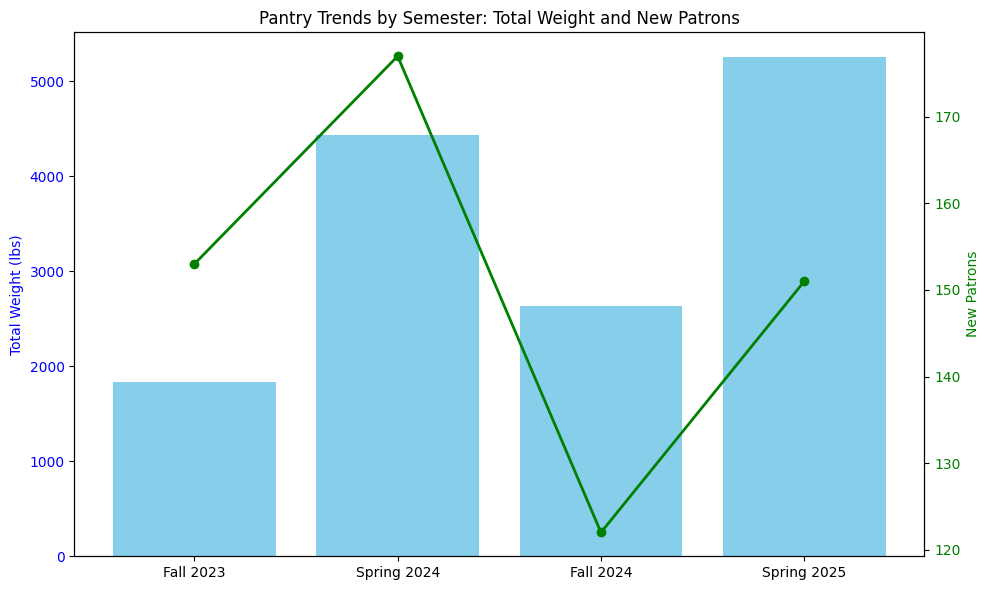

In [17]:
# Plotting using matlab
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Left Y-axis: Total Weight (Bar Chart)
ax1.bar(summary['Semester'], summary['Weight'], color='skyblue', label='Total Weight')
ax1.set_ylabel('Total Weight (lbs)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Right Y-axis: New Patrons (Line Chart)
ax2 = ax1.twinx()
ax2.plot(summary['Semester'], summary['New Patrons'], color='green', marker='o', linewidth=2, label='New Patrons')
ax2.set_ylabel('New Patrons', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and formatting
plt.title('Pantry Trends by Semester: Total Weight and New Patrons')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [18]:
# What does this analysis mean for the Carolina Cupboard. We start by assuming that every patron is new. This shows that more new patrons find out 
# about the Carolina Cupboard during the Spring, and there isn't much carry over into the next year. This can possibly be explained by a variety of factors. 
# Maybe it is because most people taking from the pantry live on campus, as the pantry is near the freshman dorms. And because many underclassman 
# may not know it exists, and slowly find out, is what is causing the rise in trend. 
# The cupboard shows a high increase in the second year (school years start in the fall), showing 
# steady increased growth. So, after using the pantry, people are more likely to use it again.
# Additionally, there is more overall use during the spring semesters than the fall, as more people learn about the 
# Cupboard throughout the year. This is shown by the steadily increasing amount of new patrons from the Fall to the Spring semester. 


In [19]:
# Counting total visits per Patron
visit_counts = df.groupby('PID').size().reset_index(name='VisitCount')
print(visit_counts)
repeat_visitors = visit_counts[visit_counts['VisitCount'] > 1]
avg_repeat_visits = repeat_visitors['VisitCount'].mean()
print(f"Average visits per repeat patron: {avg_repeat_visits:.2f}")


                PID  VisitCount
0          73040205           1
1          73047304           1
2          73055889           2
3          73056763           1
4          73057180           1
..              ...         ...
605  (None written)           1
606               -           3
607            ----           6
608         -------           2
609   -------------           1

[610 rows x 2 columns]
Average visits per repeat patron: 4.86


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


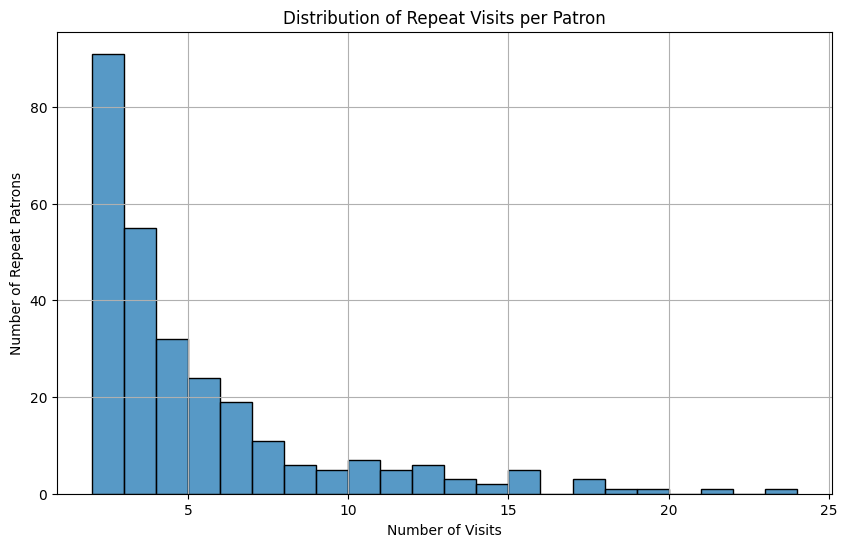

In [33]:
# Histogram Plot of repeat visit frequency

import seaborn as sns

repeat_visitors = repeat_visitors.copy()
repeat_visitors['VisitCount'] = repeat_visitors['VisitCount'].replace([np.inf, -np.inf], np.nan)
repeat_visitors = repeat_visitors.dropna(subset=['VisitCount'])

plt.figure(figsize=(10, 6))
sns.histplot(repeat_visitors['VisitCount'], bins=range(2, repeat_visitors['VisitCount'].max() + 2), kde=False)
plt.title('Distribution of Repeat Visits per Patron')
plt.xlabel('Number of Visits')
plt.ylabel('Number of Repeat Patrons')
plt.grid(True)
plt.show()



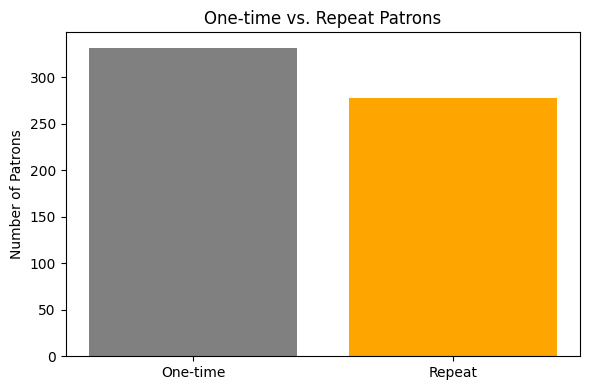

In [21]:
# Compare repeat vs one-time visitors
repeat_count = (visit_counts['VisitCount'] > 1).sum()
one_time_count = (visit_counts['VisitCount'] == 1).sum()

plt.figure(figsize=(6, 4))
plt.bar(['One-time', 'Repeat'], [one_time_count, repeat_count], color=['gray', 'orange'])
plt.title('One-time vs. Repeat Patrons')
plt.ylabel('Number of Patrons')
plt.tight_layout()
plt.show()

In [22]:
# Predicting the next few semesters using a regression model
# Create features
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Semester'] = df['Date'].apply(assign_semester)


In [23]:
# Aggregate daily totals
daily_df = df.groupby('Date').agg({
    'Weight': 'sum',
    'PID': 'nunique',  # visits that day
}).reset_index().rename(columns={'PID': 'UniqueVisitors'})

# Add time-based features again
daily_df['Week'] = daily_df['Date'].dt.isocalendar().week
daily_df['Month'] = daily_df['Date'].dt.month
daily_df['DayOfWeek'] = daily_df['Date'].dt.dayofweek
daily_df['Semester'] = daily_df['Date'].apply(assign_semester)

In [24]:
# creating a freature that adds a time trend, better represeting the upward time trend in demand
min_date = daily_df['Date'].min()
daily_df['DaysSinceStart'] = (daily_df['Date'] - min_date).dt.days

In [25]:
# Using a semester-level feature because spring just generally has more than fall
semester_median = daily_df.groupby('Semester')['Weight'].median().to_dict()

# Map that median back to each row
daily_df['SemesterMedian'] = daily_df['Semester'].map(semester_median)
# median worked a lot better than mean because median is a more robust measure that helped take away some of the outliers


In [26]:
# Create Train and dest data by semester
train = daily_df[daily_df['Semester'].isin(['Fall 2023', 'Spring 2024'])]
test = daily_df[daily_df['Semester'].isin(['Fall 2024', 'Spring 2025'])]

In [27]:
from sklearn.linear_model import LinearRegression
# from sklearn.ensem import RandomForestRegressor (Tried, ended with a worse MSE than the linear regression)
from sklearn.metrics import mean_squared_error


# Features to use
features = ['Week', 'Month', 'DayOfWeek', 'UniqueVisitors', 'SemesterMedian'] # adding ''model = 'DaysSinceStart' made MSE worse

# Train and test sets
X_train = train[features]
y_train = train['Weight']
X_test = test[features]
y_test = test['Weight']

# Train the model
# model = RandomForestRegressor(n_estimators=100, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MSE: 1539.93


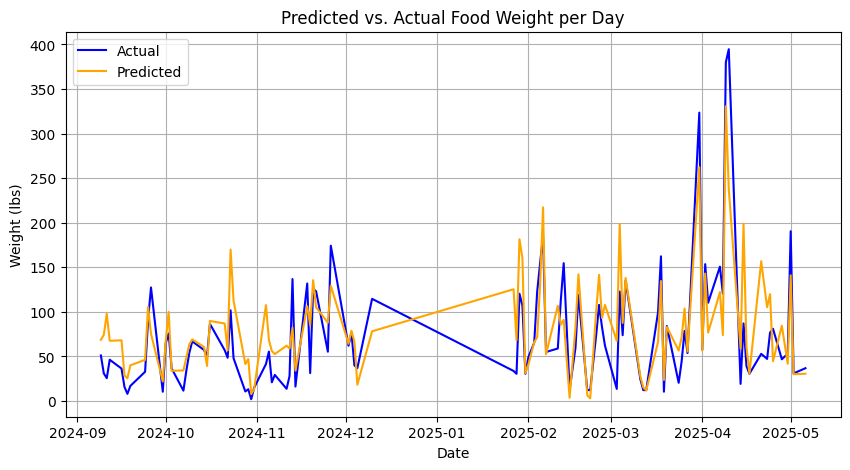

In [29]:
# Plotting it
import matplotlib.pyplot as plt

test = test.copy()
test.loc[:, 'Predicted Weight'] = y_pred

plt.figure(figsize=(10, 5))
plt.plot(test['Date'], test['Weight'], label='Actual', color='blue')
plt.plot(test['Date'], test['Predicted Weight'], label='Predicted', color='orange')
plt.title('Predicted vs. Actual Food Weight per Day')
plt.ylabel('Weight (lbs)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()
